In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from tqdm import tqdm
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

In [3]:
## Download checkpoint for base 8x8 model
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    
## download base 8x8 2-frame model
base8x8_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_baseVMAE_224px_8x8patches_2frames.pth'
!wget -nc --show-progress -P $model_checkpoint_dir $base8x8_url

--2023-06-03 18:11:45--  https://counterfactual-world-modeling.s3.amazonaws.com/cwm_baseVMAE_224px_8x8patches_2frames.pth
Resolving counterfactual-world-modeling.s3.amazonaws.com (counterfactual-world-modeling.s3.amazonaws.com)... 52.216.209.81, 52.217.89.180, 52.216.86.139, ...
Connecting to counterfactual-world-modeling.s3.amazonaws.com (counterfactual-world-modeling.s3.amazonaws.com)|52.216.209.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1112201777 (1.0G) [binary/octet-stream]
Saving to: ‘../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth’

cwm_baseVMAE_224px_ 100%[===================>]   1.04G  22.3MB/s    in 46s     

2023-06-03 18:12:31 (23.0 MB/s) - ‘../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth’ saved [1112201777/1112201777]



In [4]:
## build and load a VMAE pretrained with the temporally-factored masking policy
import cwm.models.VideoMAE.vmae as vmae

DEVICE = torch.device('cpu')
USE_GPU = True

if torch.cuda.is_available() and USE_GPU:
    DEVICE = torch.device('cuda:0')
elif torch.backends.mps.is_available() and USE_GPU:
    DEVICE = torch.device('mps')
    
USE_FLASH = 'cuda' in str(DEVICE.type)

model_func = vmae.base_8x8patch_2frames_1tube
model_path = os.path.join(model_checkpoint_dir, base8x8_url.split('/')[-1])

model = vmae.base_8x8patch_2frames_1tube(use_flash_attention=(USE_FLASH))
model.eval().requires_grad_(False).to(DEVICE)
print("Num parameters: %d" % sum([v.numel() for v in model.parameters()]))

did_load = model.load_state_dict(torch.load(model_path, map_location='cpu')['model'])
print(did_load, model_func.__name__, model_path, "device: %s" % DEVICE)

NUM PATCHES IN ENCODER 1568
Num parameters: 92661312
<All keys matched successfully> base_8x8patch_2frames_1tube ../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth device: mps


In [5]:
'''
Create a way of generating mask inputs to the model, and wrap it for easy prediction
We call the model wrapper Psi, whose main method is making a prediction, y, via
 
      y = Psi.predict(x, mask)
      
where
     - x is a video of shape (B,2,3,*model.img_size)
     - mask is a boolean mask of shape (B, num_patches), with num_patches = np.prod(model.mask_size)
     
'''

import cwm.models.masking as masking
import cwm.models.prediction as prediction

MASK_RATIO = 0.99
CLUMPING_FACTOR = 1

# an object that generates temporally-factored masks. mask_ratio of the second frame is masked out.
# clumping_factor determines how much visible patches will be clumped (default 1)
mask_generator = masking.RotatedTableUniformMaskingGenerator(
    input_size=model.mask_size,
    mask_ratio=MASK_RATIO,
    clumping_factor=CLUMPING_FACTOR,
    randomize_num_visible=False,
    always_batch=True,
    seed=0
).requires_grad_(False).to(DEVICE)

# the wrapper for making predictions
Psi = prediction.PredictorBasedGenerator(
        predictor=model, # the model function with loaded weights
        temporal_dim=2, # the base models take inputs of shape [B,3,T,H,W]; the wrapper Psi handles reshaping
        imagenet_normalize_inputs=True, # because these models were trained with normalization
        mask_generator=mask_generator, # a way of generating masks automatically if desired
        seed=0
).requires_grad_(False).to(DEVICE)

# 
mask = mask_generator()
print("\n")
print("example mask shape: %s" % list(mask.shape))
print("number of visible patches: %d" % mask.sum().item())

No predictor weights were loaded in constructing the PredictorBasedGenerator
This is fine as long as you already loaded the weights!


example mask shape: [1, 1568]
number of visible patches: 776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input shape: [1, 2, 3, 224, 224]


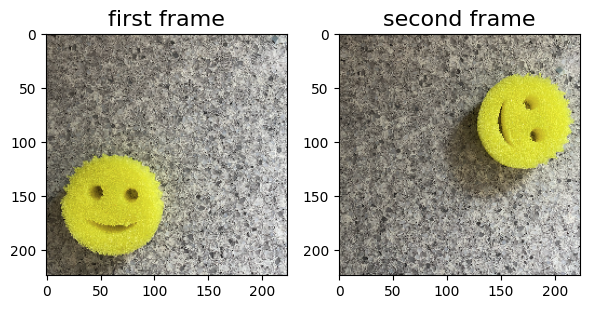

In [19]:
# create demo movie
from cwm.vis_utils import imshow
demo_images_dir = '../../CounterfactualWorldModels/demo/images/'

img1_name = 'sponge_0.png'
img2_name = 'sponge_1.png'
img1 = Image.open(os.path.join(demo_images_dir, img1_name))
img2 = Image.open(os.path.join(demo_images_dir, img2_name))

tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224], interpolation=transforms.InterpolationMode.BICUBIC),
])

x = torch.stack([tr(_img)[0:3] for _img in (img1, img2)], 0)[None].to(DEVICE)
print("input shape: %s" % list(x.shape))

fig, axes = plt.subplots(1,2,figsize=(6,3))
imshow(x, t=0, ax=axes[0], title='first frame', fontsize=16)
imshow(x, t=1, ax=axes[1], title='second frame', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


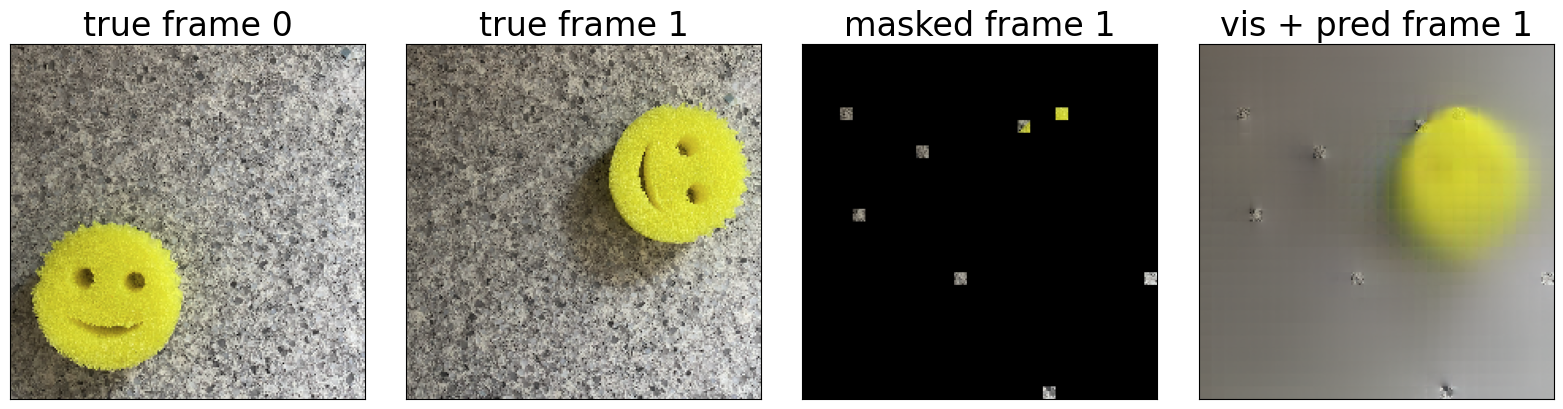

In [21]:
### generate and plot the masked prediction ###

# make the mask
mask_ratio = 0.99
Psi.mask_generator.mask_ratio = mask_ratio
mask = Psi.mask_generator(x)

# pass video and mask through model
model.to(DEVICE)
y = Psi(x, mask=mask)

# plot results
fig, axes = plt.subplots(1,4,figsize=(16,4))
titles = ['true frame 0', 'true frame 1', 'masked frame 1', 'vis + pred frame 1']

plots = [
    x[:,0], # first frame
    x[:,1], # second frame
    Psi.get_masked_pred_patches(x, mask, invert=True)[:,1], # visible patches in second frame
    y[:,1] # prediction of second frame
]

for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    imshow(plots[i], ax=ax)
    ax.set_title(titles[i], fontsize=24)

    
plt.tight_layout()
plt.show()

In [17]:
## check whether results are same on cpu
_x = x.cpu()
_mask = mask.cpu()
model.to('cpu')
y_cpu = Psi(_x, _mask)

print("gpu and cpu result match?", torch.allclose(y_cpu, y.cpu()))

gpu and cpu result match? True
